Loading all the required libraries 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier

The data was present in a json format. So i used read_json function from pandas library for create a dataframe.


In [ ]:
cc_df=pd.read_json("/content/drive/MyDrive/Data/transactions.txt",convert_dates=True, lines=True)
cc_df.head(5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


WE can see that ther are 786363 records and each record is denoted by 29 features which gives us information about all the transactions.

In [ ]:
cc_df.shape
 

(786363, 29)

In [ ]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

There are no null values present in the data. But there could be some columns which just have singe value present for all rows. 
For example: After looking at the data I found out that merchantCity column had "" values for all the rows.
Such a column is going to be of no use so we can discard them. 
If these columns have just a single value for all rows, it is going to be of no help in classifying fraud.

In [ ]:
discard_columns=[]
for i in cc_df.columns:
  if len(cc_df[i].value_counts())==1:
    discard_columns.append(i)
print("Columns to be discarded: ",discard_columns)

Columns to be discarded:  ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']


In [ ]:
cc_df.drop(discard_columns,axis=1,inplace=True)
cc_df.shape

(786363, 23)

In [ ]:
cc_df.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,4508.739089
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,6457.442068
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,0.000000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,689.910000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,2451.760000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,5291.095000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,47498.810000


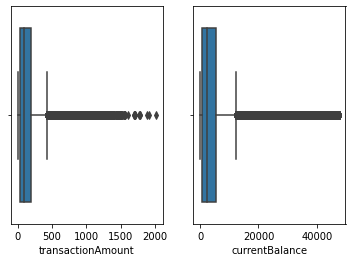

In [ ]:
fig, axes = plt.subplots(1,2)
sns.boxplot(x=cc_df["transactionAmount"],ax=axes[0])
sns.boxplot(x=cc_df["currentBalance"],ax=axes[1])


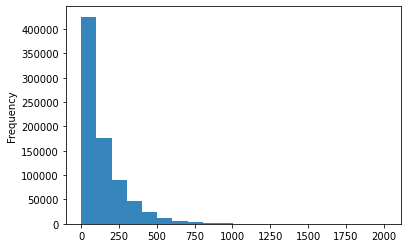

In [ ]:
cc_df["transactionAmount"].plot.hist(bins=20, alpha=0.9)

From the plots we can say that the data is present in a skewed and unnormalized format.
So, if we are using some regression or vector machines, we will first have to normalize the data.

As we will require dates for further transacctions we will convert dates from object to datetime values 

In [ ]:
cc_df['transactionDateTime'] = pd.to_datetime(cc_df['transactionDateTime'])
cc_df['currentExpDate'] = pd.to_datetime(cc_df['currentExpDate'])
cc_df['accountOpenDate'] = pd.to_datetime(cc_df['accountOpenDate'])
cc_df['dateOfLastAddressChange'] = pd.to_datetime(cc_df['dateOfLastAddressChange'])

1. Checking for reversed transactions

- I initially seperated the data based on purchase and reversal transactionType. I though of using a merge function on them using accountNumber, amount,merchantName to find out identical transactions which had gotten reversed. But as our dataset is very big, the merge operation kept failing.
- Hence I tried an iterative approach

In [ ]:

# merged=purchases.merge(reversal, on='accountNumber', how='inner', indicator=True) \
#     .query(purchases.transactionAmount==reversal.transactionAmount)

# merged.head(10)

purchases=cc_df[cc_df.transactionType=="PURCHASE"]
reversal=cc_df[cc_df.transactionType=="REVERSAL"]
print(purchases.shape,reversal.shape)
count=0
totaltransactionAmount=0
for val,cost,merchant in zip(reversal.accountNumber,reversal.transactionAmount,reversal.merchantName):
  dd=purchases[(purchases.accountNumber==val) & (purchases.merchantName==merchant)]
  if dd[dd.transactionAmount==cost].shape[0]==1:
    totaltransactionAmount+=cost
    count+=1
print(count," Total transaction amount: ",totaltransactionAmount)




(745193, 23) (20303, 23)
17447  Total transaction amount:  2624724.369999987


Hence we have total 17447 transactions which are reversal transactions and total amount of these transactions is 2624724 dollars 

In [ ]:
cc_df=cc_df.sort_values(by=["accountNumber","transactionAmount","transactionDateTime"])
cc_df = cc_df.reset_index(drop=True)

2. Multi-swipe transactions
-  Firstly, I sorted the data by accountNumber and then transactionAmount.
- Here we are only concerned with trasactionType="Purchase". I am not taking address verification into consideration becasue for that the transaction amounts are mostly zero.
- Simply checking lagged data to see if there was a repeated transaction in becasue if it is a multi swipe transaction then it should have occured in a very short span of time i.e. within a minute or two and its not possible that the user will make iany other transaction in such a short span of time 

In [ ]:
count=0
totalAmt=0
purchases=cc_df[cc_df.transactionType=="PURCHASE"].reset_index(drop=True)
# print(purchases.index)
# for i in range(len(purchases.index)):
#   if i>0 and purchases.index[i]-purchases.index[i-1]!=1:
#     print(purchases.index[i],purchases.index[i-1])
for idx,rows in purchases.iterrows():
  # print(idx)
  if idx>0 and purchases.iloc[idx].transactionType=="PURCHASE" and purchases.iloc[idx].accountNumber==purchases.iloc[idx-1].accountNumber\
   and purchases.iloc[idx].transactionAmount==purchases.iloc[idx-1].transactionAmount and \
  abs(purchases.iloc[idx].transactionDateTime.date()-purchases.iloc[idx-1].transactionDateTime.date()).total_seconds()<60 and\
   purchases.iloc[idx].merchantName==purchases.iloc[idx-1].merchantName:
    count+=1
    totalAmt+=purchases.iloc[idx].transactionAmount
    # print(min_df.iloc[idx].accountNumber,min_df.iloc[idx].transactionDateTime,min_df.iloc[idx].transactionAmount)
print("Number of multiswap oerations: ",count,"Total amount: ",totalAmt)

Number of multiswap oerations:  7443 Total amount:  1102145.0600000024


Hence the number of multiswap transactions which have occured are 7443 and total value without taking the first transaction into consideration is 1102145 dollars 

In [ ]:
isFraud=cc_df[cc_df.isFraud==True]
notFraud=cc_df[cc_df.isFraud==False]
isFraud.shape,notFraud.shape

((12417, 23), (773946, 23))

/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


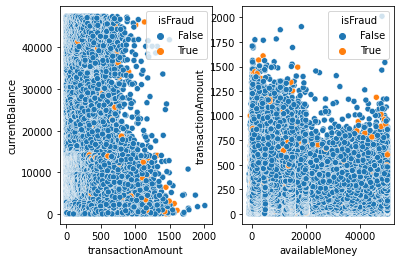

In [ ]:
fig, axes = plt.subplots(1,2)
sns.scatterplot(data=cc_df, x="transactionAmount", y="currentBalance",hue="isFraud",ax=axes[0])
sns.scatterplot(data=cc_df, x="availableMoney", y="transactionAmount",hue="isFraud",ax=axes[1])


(786363, 23)


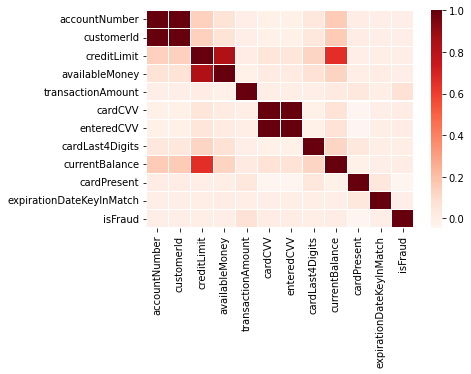

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
print(cc_df.shape)
corr = cc_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

- From the correlation plot we can see that currentBalance and creditLimit are higlhy correlated and using them both in the model could lead to multi-collinearity issues. Hence e can drop one of the columns.
- Columns like enteredCVV and cardCVV are also mismated only for non fraud values. Hence they wont be good indicators for classification. I dropped those columns too.
- CustomerId and AccountNumber are unique key ids so I dropped them. 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

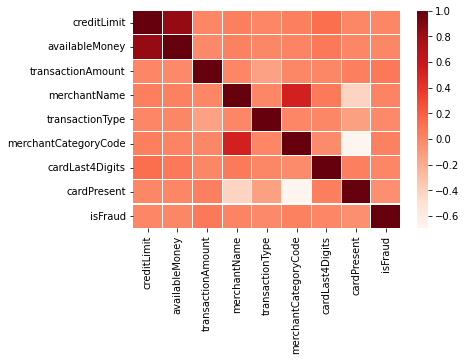

,creditLimit,availableMoney,transactionAmount,merchantName,transactionType,merchantCategoryCode,cardLast4Digits,cardPresent,isFraud
0,50000,49856.19,0.25,1531,1,3,2077,1,0
1,50000,49560.51,1.14,34,1,3,2077,1,0
2,50000,50000.00,3.96,43,1,12,4615,0,0
3,50000,49695.85,3.96,43,1,12,4615,0,0
4,50000,50000.00,3.96,43,1,12,4615,0,0


In [ ]:
le = preprocessing.LabelEncoder()

pred_cols=["creditLimit","availableMoney","transactionAmount","merchantName","transactionType",\
           "merchantCategoryCode","cardLast4Digits","cardPresent","isFraud"]
pred_df=cc_df[pred_cols]
pred_df['merchantName'] = le.fit_transform(pred_df.merchantName.values)
pred_df['merchantCategoryCode'] = le.fit_transform(pred_df.merchantCategoryCode.values)
# pred_df.drop(["merchantCity","merchantState","merchantZip"],axis=1,inplace=True)
pred_df['isFraud'] = le.fit_transform(pred_df.isFraud.values)
# pred_df.isFraud=pred_df.isFraud.map({False:0,True:1})
pred_df.cardPresent=pred_df.cardPresent.map({False:0,True:1})
pred_df.transactionType=pred_df.transactionType.map({"PURCHASE":1,"REVERSAL":2,"ADDRESS_VERIFICATION":3,"":0})

corr = pred_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()


pred_df.head(5)

Our class distribution is imbalanced, we have very less information for relevant class data i.e. isFraud.
Hence we can try diifferent data augmentation techniques to upscale or downscale the data. 
Given the situation, it is better to upscale the data so that we do not lose any important datapoints. 

I tried to use SMOTE data augmentation technique but found out that the fraud and not fraud datapoints are too close to each other and there is not clear distiguition between them. IT can be seen in the scatter plot that the points are too close and hence using SMOTE will not be helpful, it will just confuse the model more.

In [ ]:
augment=pred_df[pred_df.isFraud==1]
print(pred_df.shape,augment.shape)
pred_df=pd.concat([pred_df,augment,augment,augment],ignore_index=True)
pred_df.shape

(786363, 9) (12417, 9)


(823614, 9)

In [ ]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823614 entries, 0 to 823613
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   creditLimit           823614 non-null  int64  
 1   availableMoney        823614 non-null  float64
 2   transactionAmount     823614 non-null  float64
 3   merchantName          823614 non-null  int64  
 4   transactionType       823614 non-null  int64  
 5   merchantCategoryCode  823614 non-null  int64  
 6   cardLast4Digits       823614 non-null  int64  
 7   cardPresent           823614 non-null  int64  
 8   isFraud               823614 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 56.6 MB


- 



In [ ]:
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.30
X=pred_df.iloc[:,:-1]
y=pred_df.iloc[:,-1]
train_X,test_X,train_y,test_y= train_test_split(X,y, test_size=TEST_SIZE, shuffle=True, stratify=y )
train_X,valid_X,train_y,valid_y = train_test_split(train_X,train_y, test_size=VALID_SIZE, shuffle=True, stratify=train_y )



In [ ]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 1

clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                        
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)
clf.fit(train_X, train_y.values)

RandomForestClassifier(n_jobs=1, verbose=False)

In [ ]:
preds=clf.predict(test_X)

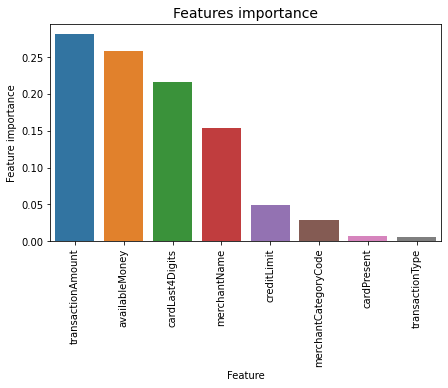

In [ ]:
from matplotlib import pyplot as plt
tmp = pd.DataFrame({'Feature': train_X.columns, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

In [ ]:
roc_auc_score(test_y.values, preds)

0.9652181898171052

In [ ]:
confusion_matrix(test_y.values,preds)

array([[231850,    335],
       [  1015,  13885]])

In [ ]:
precision,recall,fscore,_=precision_recall_fscore_support(test_y.values,preds)
print("Precision: ",precision[0],"Recall: ",recall[0])
print("Fscore: ",fscore[0])

Precision:  0.9956412513688189 Recall:  0.9985571850033379
Fscore:  0.9970970863348028


- Further improvement, I could have tried using other classifier models lile boosting techniques as they robust to overfitting or SVM models.
- I could also try out some neural network architectures to check if ther is any Fscore improvement. 
- I could try out some further feature extraction methods to try to get some more infomration from the current features to find out any pattern or behaviour or any peculiar traces of fraud. 
- Also, could use K-fold stratified cross validation. But normal stratified hold out method is giving good enough accuracy hence I didnt use K-fold technique, but could implement that in future.
